In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [8]:
# Load les datas dans le dossier Data B2 en créant une datafram pour chaque fichier excel:
bench_ligne=pd.read_csv('data/raw/bench_lignes.csv',)
caracteristique_part=pd.read_csv('data/raw/caracteristiques_parts.csv')
fixing=pd.read_csv('data/raw/fixing.csv')
frais=pd.read_csv('data/raw/frais.csv')
taux_historique=pd.read_csv('data/raw/historique_taux.csv')
passif_annee_2=pd.read_csv('data/raw/passif_annee_2_albert_school.csv')
perf_bench=pd.read_csv('data/raw/perf_bench.csv')
perf_fond=pd.read_csv('data/raw/perf_fonds.csv')
position_euro_high_yield=pd.read_csv('data/raw/positions_eurohighyield.csv')
usgg10_year_index=pd.read_csv('data/raw/usgg10yr_index.csv')
passif_yield=pd.read_csv('data/processed/passif_EHY.csv')
bench_yield=pd.read_csv('data/processed/bench_lignes_EHY.csv')
caracteristique_yield=pd.read_csv('data/processed/caracteristiques_parts_EHY.csv')

/var/folders/_g/czqmm0yj2j34w8b313f37p300000gn/T/ipykernel_87925/4213591226.py:10: DtypeWarning: Columns (0,1,2,4,5,6,7,8,9,16) have mixed types. Specify dtype option on import or set low_memory=False.
  position_euro_high_yield=pd.read_csv('data/raw/positions_eurohighyield.csv')


In [9]:
# Vérification des types de colonnes
print(passif_yield.dtypes)

# Convertir les colonnes en types appropriés
passif_yield['Net Inflows MTD (€)'] = pd.to_numeric(passif_yield['Net Inflows MTD (€)'], errors='coerce')
passif_yield['Net Inflows YTD (€)'] = pd.to_numeric(passif_yield['Net Inflows YTD (€)'], errors='coerce')
passif_yield['AUM (€)'] = pd.to_numeric(passif_yield['AUM (€)'], errors='coerce')
passif_yield['Date'] = pd.to_datetime(passif_yield['Date'], errors='coerce')

# Vérification des valeurs manquantes
print(passif_yield.isnull().sum())

Owner                                                                               object
Business Relationship                                                               object
Fund                                                                                object
Share                                                                               object
Share Type                                                                          object
ISIN                                                                                object
Date                                                                                object
AUM (€)                                                                            float64
Quantity                                                                             int64
Net Inflows YTD (€)                                                                  int64
Net Inflows MTD (€)                                                                  int64

In [10]:
# Suppression des lignes avec des dates ou flux manquants
passif_yield_cleaned = passif_yield.dropna(subset=['Date', 'Net Inflows MTD (€)', 'Net Inflows YTD (€)'])

In [11]:
# Ajouter des colonnes 'Year', 'Quarter', et 'Semester'
passif_yield_cleaned['Year'] = passif_yield_cleaned['Date'].dt.year
passif_yield_cleaned['Quarter'] = passif_yield_cleaned['Date'].dt.to_period('Q')
passif_yield_cleaned['Semester'] = passif_yield_cleaned['Date'].dt.to_period('6M')

In [12]:
# Créer une fonction pour catégoriser les segments
def categorize_segment(segment):
    if 'Bank' in segment:
        return 'Bank'
    elif 'Insurance' in segment:
        return 'Insurance'
    elif 'AM company' in segment:
        return 'AM company'
    elif 'Pension Fund' in segment:
        return 'Pension Fund'
    elif 'Financial Advisor' in segment:
        return 'Financial Advisor'
    elif 'Single Family Office' in segment:
        return 'Single Family Office'
    elif 'Consultant' in segment:
        return 'Consultant'
    else:
        return 'Other'

# Appliquer la fonction à la colonne BR Segmentation
passif_yield_cleaned['Segment_Type'] = passif_yield_cleaned['BR Segmentation (Business Relationship) (Business Relationship)'].apply(categorize_segment)

# Vérifier les nouvelles catégories
print(passif_yield_cleaned['Segment_Type'].value_counts())

Segment_Type
Bank                    4837
Insurance               1541
AM company              1103
Financial Advisor        271
Other                    167
Pension Fund              48
Single Family Office      39
Consultant                 4
Name: count, dtype: int64


In [13]:
# Extraire la devise (partie après le dernier tiret)
passif_yield_cleaned['Currency'] = passif_yield_cleaned['Share'].str.extract(r'- (\w+)$')

# Vérifier les nouvelles colonnes créées
print(passif_yield_cleaned[['Share', 'Share Type', 'Currency']].head())

                              Share Share Type Currency
0  EdR Fund Euro High Yield A - EUR          A      EUR
1  EdR Fund Euro High Yield A - EUR          A      EUR
2  EdR Fund Euro High Yield A - EUR          A      EUR
3  EdR Fund Euro High Yield A - EUR          A      EUR
4  EdR Fund Euro High Yield I - EUR          I      EUR


In [14]:
# Créer la colonne Profile
passif_yield_cleaned['Profile'] = passif_yield_cleaned['Share Type'] + ' - ' + passif_yield_cleaned['Currency']

# Vérifier les valeurs uniques
print(passif_yield_cleaned['Profile'].unique())

['A - EUR' 'I - EUR' 'R - EUR' 'B - EUR' 'J - EUR' nan 'CR - EUR'
 'O - EUR' 'K - EUR' 'N - EUR' 'A - CHF']


In [17]:
# Grouper les données par critères clés de segmentation
segmentation_clients = (
    passif_yield_cleaned.groupby([
        'Segment_Type',          # Typologie des clients
        'Share Type',               # Type de part
        'Currency',                 # Devise
        'Profile',                  # Profil combiné
        'Business Country (Business Relationship) (Business Relationship)'  # Pays d'origine
        ,'Date',
        'Year', 'Quarter', 'Semester'  # Informations temporelles
    ])[['Net Inflows MTD (€)', 'Net Inflows YTD (€)', 'AUM (€)']]  # Variables financières
    .sum()  # Somme des valeurs pour chaque segment
    .reset_index()
    .sort_values(by='Net Inflows MTD (€)', ascending=False)  # Trier par flux nets MTD
)

# Afficher les résultats
print("Segmentation détaillée des clients :")
segmentation_clients.head(10)  # Afficher les 10 premières lignes

Segmentation détaillée des clients :


,Segment_Type,Share Type,Currency,Profile,Business Country (Business Relationship) (Business Relationship),Date,Year,Quarter,Semester,Net Inflows MTD (€),Net Inflows YTD (€),AUM (€)
1995,Insurance,A,EUR,A - EUR,FRANCE,2022-08-31 06:00:00,2022,2022Q3,2022-08,26285847,25382298,33885201.0
2000,Insurance,A,EUR,A - EUR,FRANCE,2023-01-31 05:00:00,2023,2023Q1,2023-01,16706218,16706218,54682389.0
364,AM company,I,EUR,I - EUR,WORLD,2020-10-31 05:00:00,2020,2020Q4,2020-10,15910596,14336147,16998142.0
1464,Bank,I,EUR,I - EUR,ITALY,2023-04-30 06:00:00,2023,2023Q2,2023-04,10674509,12320214,14386684.0
1437,Bank,I,EUR,I - EUR,AUSTRIA,2022-01-31 05:00:00,2022,2022Q1,2022-01,8387855,8387855,8277615.0
271,AM company,I,EUR,I - EUR,FRANCE,2024-02-29 05:00:00,2024,2024Q1,2024-02,7994542,7511562,8015910.0
2199,Insurance,N,EUR,N - EUR,FRANCE,2022-12-31 05:00:00,2022,2022Q4,2022-12,6883253,8599911,8506475.0
2200,Insurance,N,EUR,N - EUR,FRANCE,2023-01-31 05:00:00,2023,2023Q1,2023-01,6331513,6331513,15122414.0
2003,Insurance,A,EUR,A - EUR,FRANCE,2023-04-30 06:00:00,2023,2023Q2,2023-04,5785391,23353169,61270048.0
388,AM company,I,EUR,I - EUR,WORLD,2022-10-31 05:00:00,2022,2022Q4,2022-10,5573382,3168957,7077077.0


array(['A - EUR', 'I - EUR', 'N - EUR', 'B - EUR', 'K - EUR', 'J - EUR',
       'R - EUR', 'CR - EUR', 'O - EUR', 'A - CHF'], dtype=object)

<Axes: xlabel='Segment_Type'>

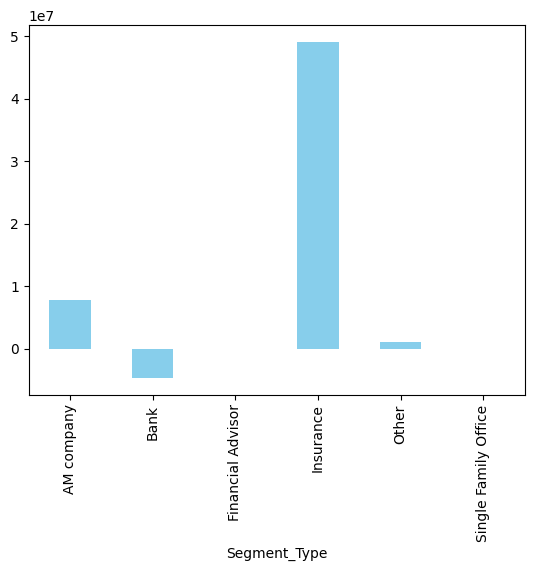

In [32]:
segmentation_clients.groupby('Segment_Type')['Net Inflows MTD (€)'].sum().plot(kind='bar', color='skyblue')

<Axes: xlabel='Profile'>

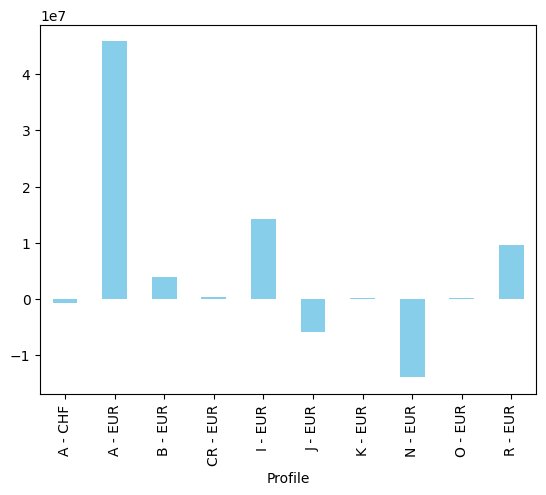

In [34]:
segmentation_clients.groupby('Profile')['Net Inflows MTD (€)'].sum().plot(kind='bar', color='skyblue')

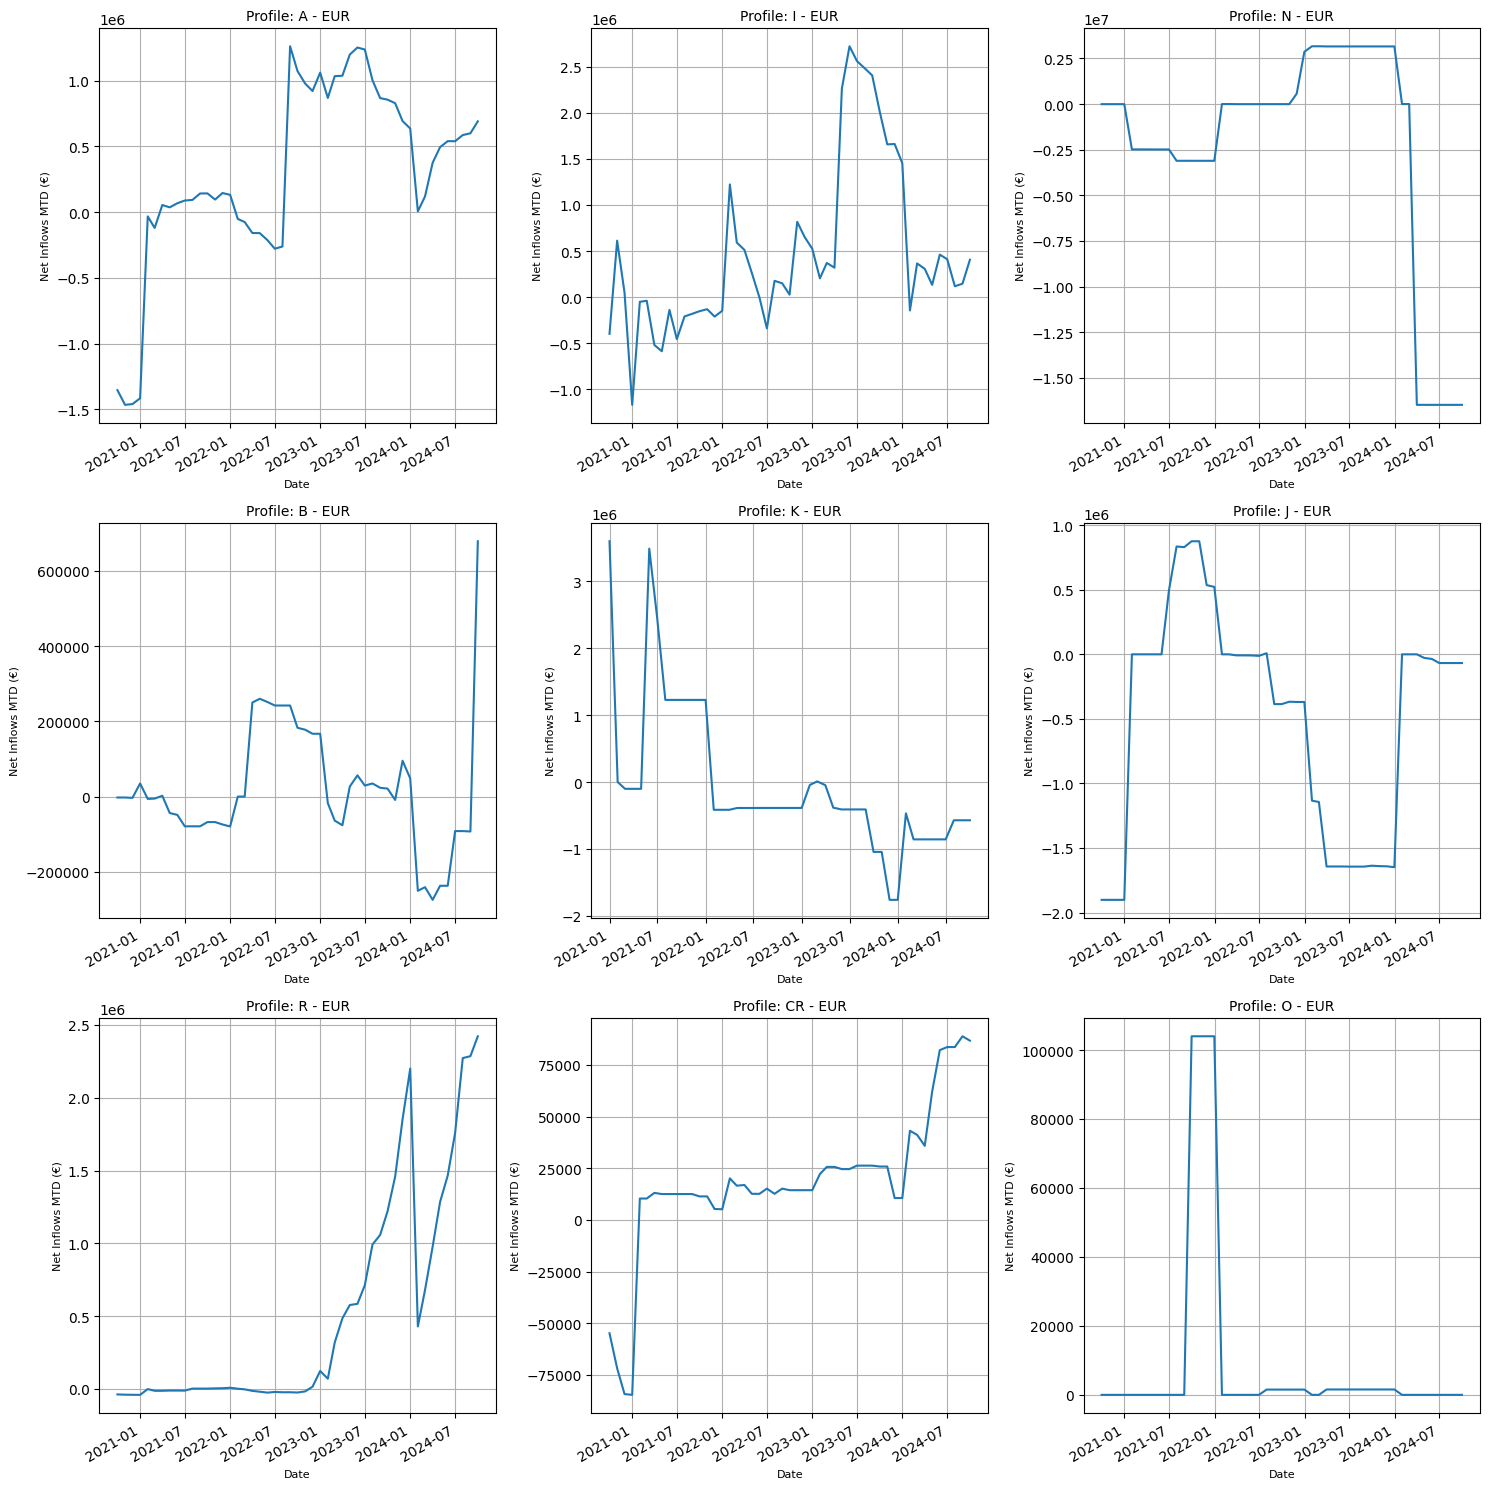

In [44]:
profiles = ['A - EUR', 'I - EUR', 'N - EUR', 'B - EUR', 'K - EUR', 'J - EUR', 'R - EUR', 'CR - EUR', 'O - EUR', 'A - CHF']

plt.figure(figsize=(15, 15))

for i, profile in enumerate(profiles[:9], 1):
    plt.subplot(3, 3, i)
    segmentation_clients.query(f'Profile == "{profile}"').groupby('Date')['Net Inflows YTD (€)'].mean().plot()
    plt.title(f'Profile: {profile}', fontsize=10)
    plt.xlabel('Date', fontsize=8)
    plt.ylabel('Net Inflows MTD (€)', fontsize=8)
    plt.grid(True)

plt.tight_layout()
plt.show()

<Axes: xlabel='Date'>

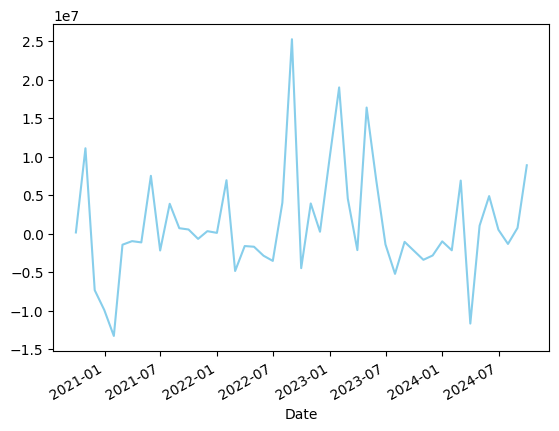

In [79]:
segmentation_clients.groupby('Date')['Net Inflows MTD (€)'].sum().plot(kind='line', color='skyblue')

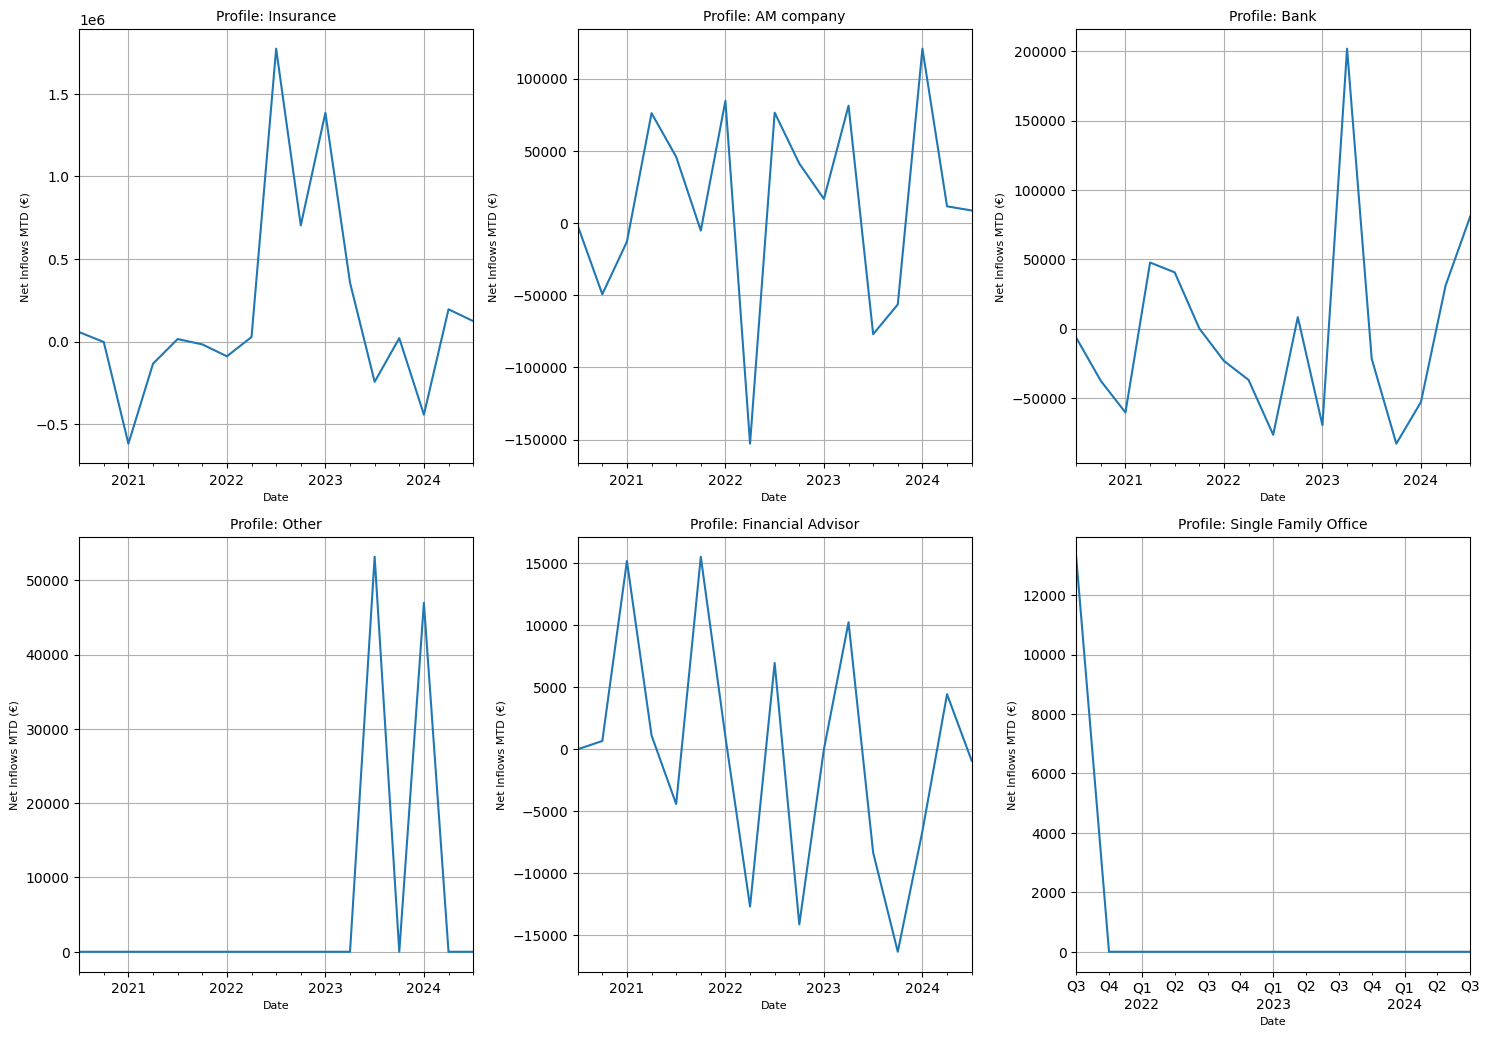

In [63]:
profiles = ['Insurance', 'AM company', 'Bank', 'Other', 'Financial Advisor','Single Family Office']

segmentation_clients_2021 = segmentation_clients.query('Date.dt.year == 2023')  

plt.figure(figsize=(15, 15))

for i, profile in enumerate(profiles[:9], 1):
    plt.subplot(3, 3, i)
    segmentation_clients.query(f'Segment_Type == "{profile}"').groupby('Quarter')['Net Inflows MTD (€)'].mean().plot()
    plt.title(f'Profile: {profile}', fontsize=10)
    plt.xlabel('Date', fontsize=8)
    plt.ylabel('Net Inflows MTD (€)', fontsize=8)
    plt.grid(True)

plt.tight_layout()
plt.show()

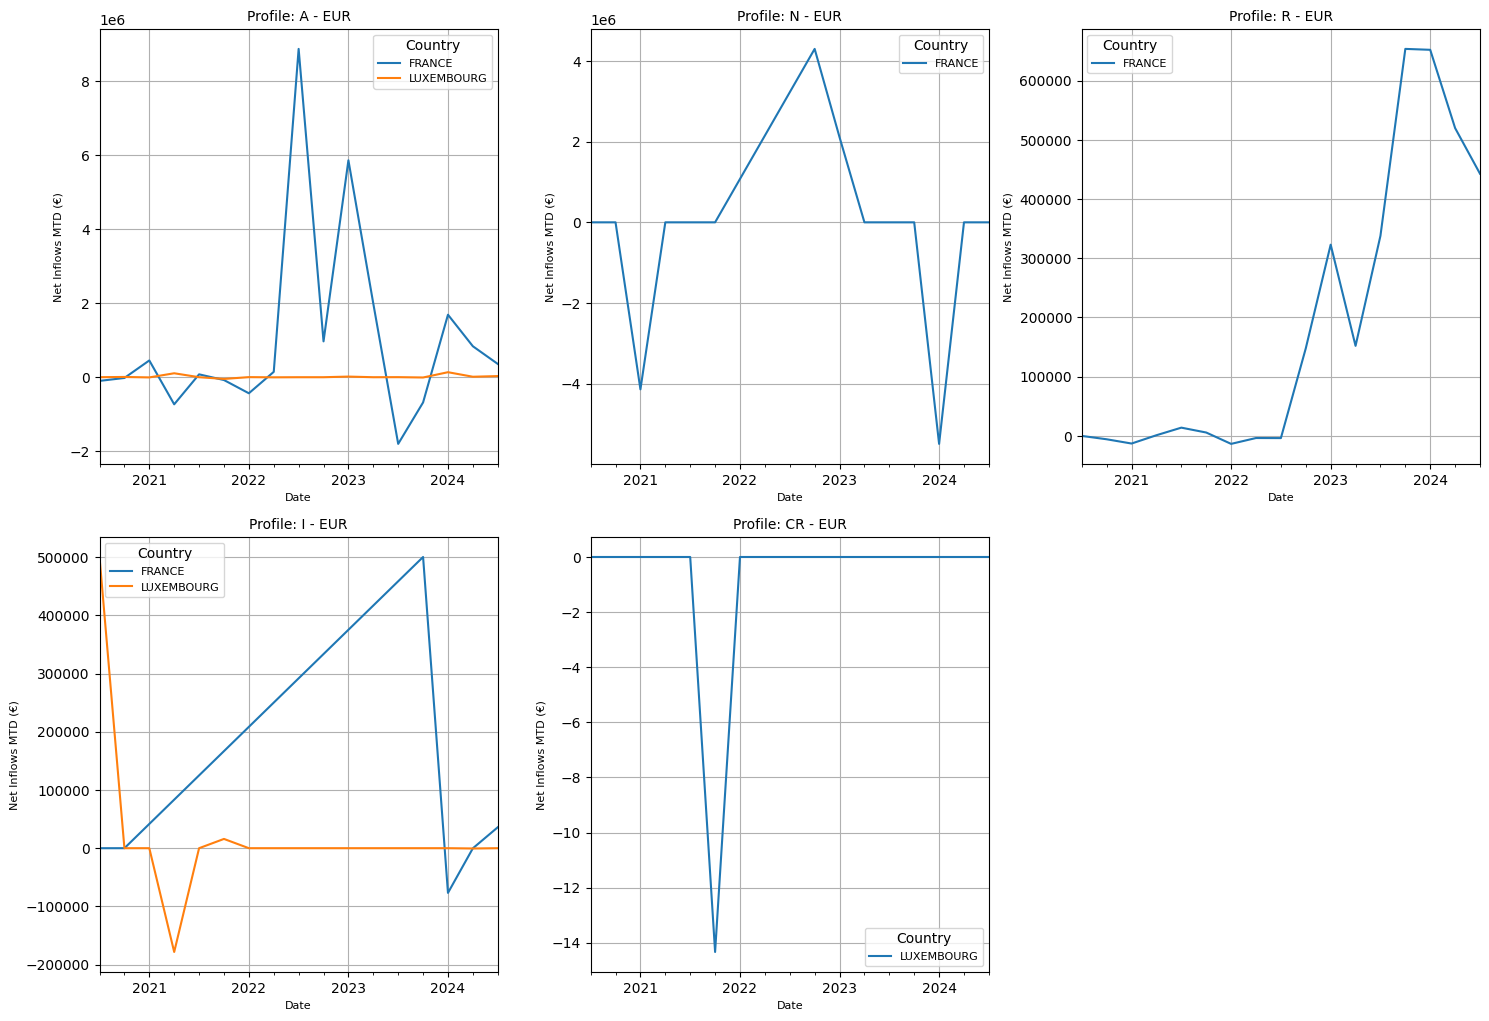

In [71]:
insurance_profiles = segmentation_clients.query('Segment_Type == "Insurance"')['Profile'].unique()

plt.figure(figsize=(15, 15))

for i, profile in enumerate(insurance_profiles, 1):
    plt.subplot(3, 3, i)
    for country in segmentation_clients.query(f'Segment_Type == "Insurance" and Profile == "{profile}"')['Business Country (Business Relationship) (Business Relationship)'].unique():
        segmentation_clients.query(f'Segment_Type == "Insurance" and Profile == "{profile}" and `Business Country (Business Relationship) (Business Relationship)` == "{country}"').groupby('Quarter')['Net Inflows MTD (€)'].mean().plot(label=country)
    plt.title(f'Profile: {profile}', fontsize=10)
    plt.xlabel('Date', fontsize=8)
    plt.ylabel('Net Inflows MTD (€)', fontsize=8)
    plt.legend(title='Country', fontsize=8)
    plt.grid(True)

plt.tight_layout()
plt.show()

array(['I - EUR', 'B - EUR', 'A - EUR', 'J - EUR', 'CR - EUR', 'O - EUR',
       'K - EUR', 'R - EUR', 'N - EUR', 'A - CHF'], dtype=object)

ValueError: num must be an integer with 1 <= num <= 5, not 6

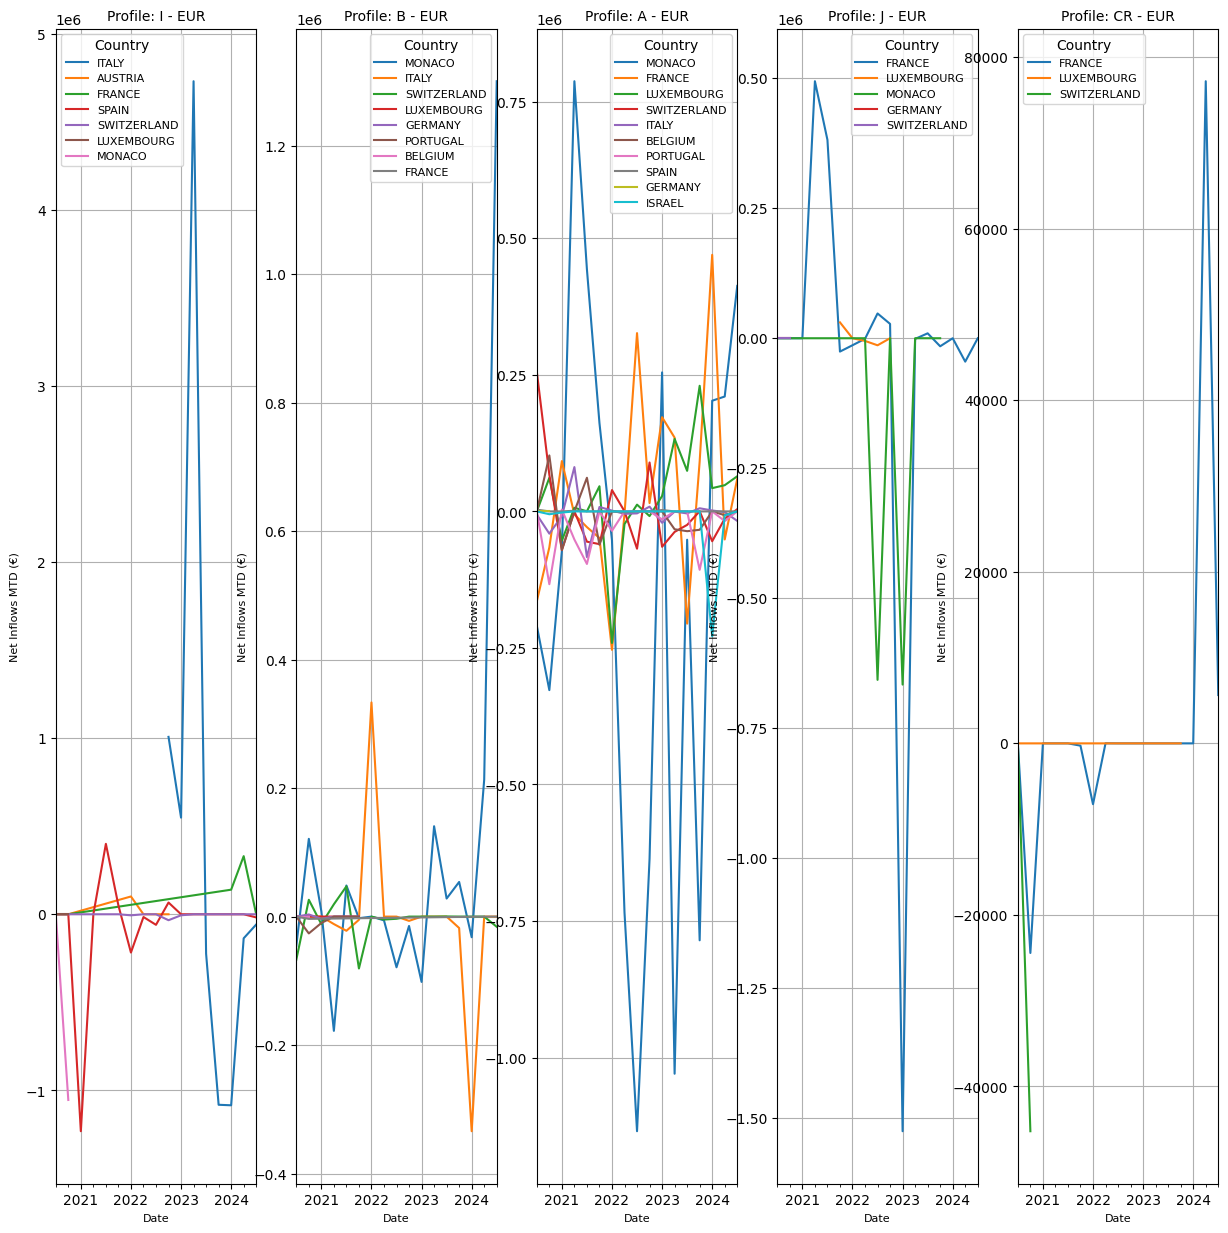

In [81]:
insurance_profiles = segmentation_clients.query('Segment_Type == "Bank"')['Profile'].unique()

plt.figure(figsize=(15, 15))

for i, profile in enumerate(insurance_profiles, 1):
    plt.subplot(1, 5, i)
    for country in segmentation_clients.query(f'Segment_Type == "Bank" and Profile == "{profile}"')['Business Country (Business Relationship) (Business Relationship)'].unique():
        segmentation_clients.query(f'Segment_Type == "Bank" and Profile == "{profile}" and `Business Country (Business Relationship) (Business Relationship)` == "{country}"').groupby('Quarter')['Net Inflows MTD (€)'].mean().plot(label=country)
    plt.title(f'Profile: {profile}', fontsize=10)
    plt.xlabel('Date', fontsize=8)
    plt.ylabel('Net Inflows MTD (€)', fontsize=8)
    plt.legend(title='Country', fontsize=8)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [83]:
segmentation_clients.Profile.unique()

array(['A - EUR', 'I - EUR', 'N - EUR', 'B - EUR', 'K - EUR', 'J - EUR',
       'R - EUR', 'CR - EUR', 'O - EUR', 'A - CHF'], dtype=object)

In [84]:
frais = pd.read_csv('data/raw/frais.csv')

In [100]:
# Liste des valeurs à garder
security_names_to_keep = [
    'EdR Fund Euro High Yield I - EUR',
    'EdR Fund Euro High Yield B - EUR',
    'EdR Fund Euro High Yield A - USD (H)',
    'EdR Fund Euro High Yield A - EUR',
    'EdR Fund Euro High Yield R - EUR',
    'EdR Fund Euro High Yield O - EUR',
    'EdR Fund Euro High Yield N - EUR',
    'EdR Fund Euro High Yield J - EUR',
    'EdR Fund Euro High Yield A - CHF'
]

# Filtrer la DataFrame frais
frais_filtered = frais[frais['SECURITY_NAME'].isin(security_names_to_keep)]
frais_filtered
frais_filtered.query('TYPE_FRAIS == "FRAIS_FIXE"').groupby('SECURITY_NAME').MONTANT_FRAIS.sum()#.groupby('').sum()


SECURITY_NAME
EdR Fund Euro High Yield A - CHF         -11131.24
EdR Fund Euro High Yield A - EUR       -4714523.11
EdR Fund Euro High Yield A - USD (H)     -24353.79
EdR Fund Euro High Yield B - EUR        -136703.29
EdR Fund Euro High Yield I - EUR        -279794.30
EdR Fund Euro High Yield J - EUR        -116140.09
EdR Fund Euro High Yield N - EUR         -56032.05
EdR Fund Euro High Yield O - EUR           -861.51
EdR Fund Euro High Yield R - EUR        -118494.68
Name: MONTANT_FRAIS, dtype: float64